# Домашнее задание №1

Ольшин Антон БМТ1-12М

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('coron_data.csv', sep=';', parse_dates=['DateTime'])
print(df.head())

    DateTime  Заражений за день  Выздоровлений за день  Смертей за день
0 2020-03-12                 34                      0                0
1 2020-03-13                 11                      0                0
2 2020-03-14                 14                      0                0
3 2020-03-15                  4                      3                0
4 2020-03-16                 28                      2                0


In [3]:
df = df.rename(columns={
    'Заражений за день' : 'Infect',
    'Выздоровлений за день' : 'Recovery',
    'Смертей за день' : 'Death'
})
df.head()

,DateTime,Infect,Recovery,Death
0,2020-03-12,34,0,0
1,2020-03-13,11,0,0
2,2020-03-14,14,0,0
3,2020-03-15,4,3,0
4,2020-03-16,28,2,0


Постоим график заражения от даты:

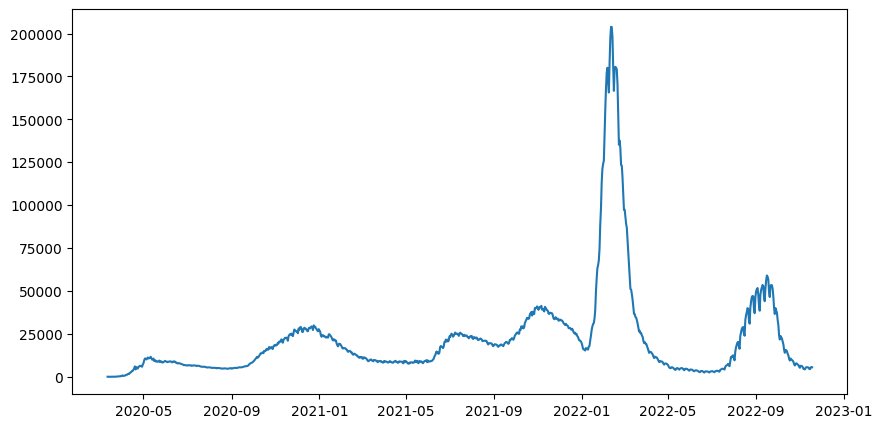

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(df.DateTime, df.Infect)

## Задание 1

Оценить высокочастотную периодичность прироста новых случаев заболевания (график "Прирост по дням")

In [5]:
df.dtypes

DateTime    datetime64[ns]
Infect               int64
Recovery             int64
Death                int64
dtype: object

### a) Переведем тип datetime64 даты в числовый тип (в дни) 

In [6]:
df.DateTime.shape[0]
df.head()

,DateTime,Infect,Recovery,Death
0,2020-03-12,34,0,0
1,2020-03-13,11,0,0
2,2020-03-14,14,0,0
3,2020-03-15,4,3,0
4,2020-03-16,28,2,0


In [7]:
date_list = []
for i in range(df.DateTime.shape[0]):
    date_list.append((df.DateTime[i] - df.DateTime[0])/  np.timedelta64(1, 'D'))
df_day = df.copy()
df_day.DateTime = date_list
df_day.head()

,DateTime,Infect,Recovery,Death
0,0.0,34,0,0
1,1.0,11,0,0
2,2.0,14,0,0
3,3.0,4,3,0
4,4.0,28,2,0


### b) Сделаем преобразование Фурье

In [8]:
new_y = np.zeros(df_day.Infect.shape)
spec = np.fft.fft(df_day.Infect)
cn = np.abs((spec.real**2 + spec.imag**2)**(1/2))
theta = np.angle(spec)
Ts = np.mean(np.diff(df_day.DateTime))
fs = 1 / Ts
fs_day = fs * 60 * 60 * 24
Ts, fs

(1.0, 1.0)

Частота дискретизации получилась 1 Гц (мы считаем в днях, так что это один день), ожидаемо



In [9]:
for n in range(len(new_y)):
    new_y += 2 * cn[n] * np.cos(2 * np.pi * fs/len(new_y) * n * df_day.DateTime  + theta[n])

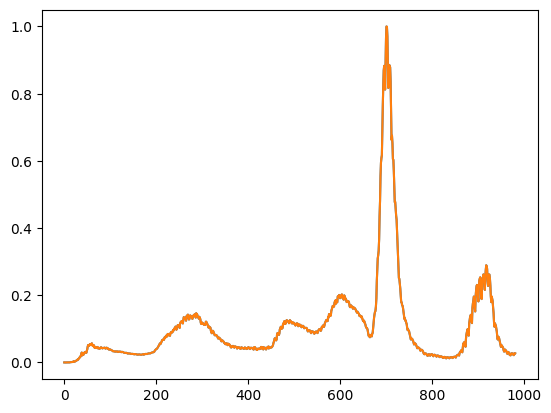

In [10]:
plt.plot(new_y / np.max(new_y))
plt.plot(df.Infect / np.max(df.Infect))


Графики совпали, возьмем меньший n, чтобы посмотреть, как они не совпадают

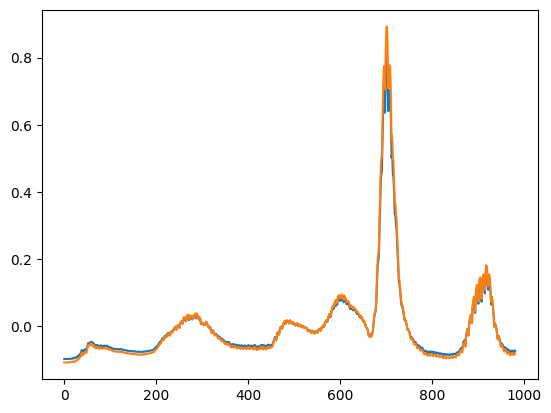

In [11]:
new_y = np.zeros(df_day.Infect.shape)
spec = np.fft.fft(df_day.Infect)
cn = np.abs((spec.real**2 + spec.imag**2)**(1/2))
theta = np.angle(spec)
Ts = np.mean(np.diff(df_day.DateTime))
fs = 1 / Ts
fs_day = fs * 60 * 60 * 24
Ts, fs
for n in range(int(len(new_y)/2)):
    new_y += 2 * cn[n] * np.cos(2 * np.pi * fs/len(new_y) * n * df_day.DateTime  + theta[n])
plt.plot((new_y - new_y.mean()) / np.max(new_y))
plt.plot((df.Infect - df.Infect.mean()) / np.max(df.Infect))

Вроде круто

### b) Найдем частоту занесения данных в таблицу

 Для нахождения 

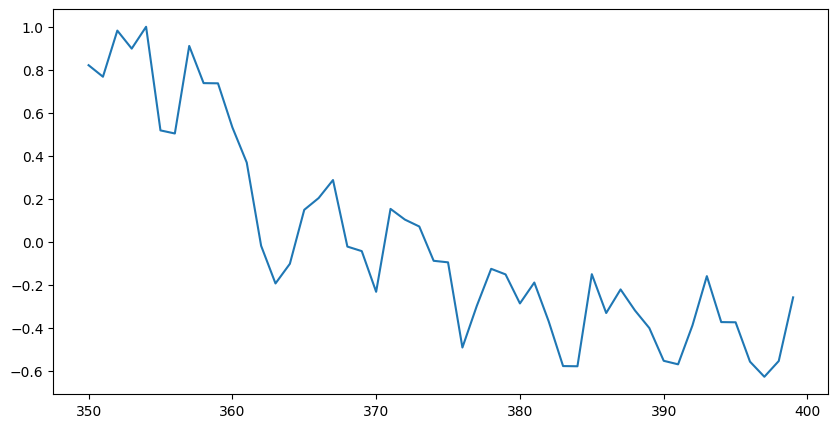

In [12]:
df_cut = df_day[350:400]
dat = df_cut.Infect - np.mean(df_cut.Infect)
dat = dat/ np.max(dat)
plt.figure(figsize=(10,5))
plt.plot(df_cut.DateTime, dat)

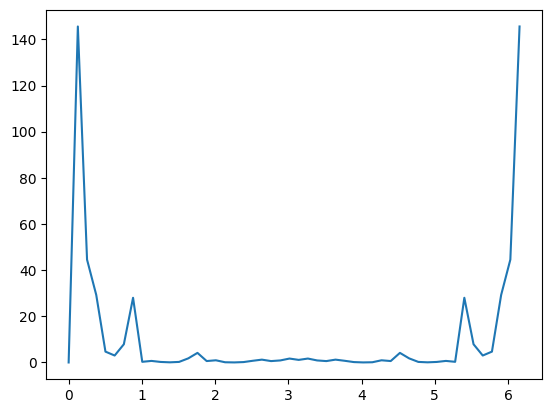

In [13]:
spectra = np.fft.fft(dat)
dens = np.abs(spectra)**2
f = np.asarray([2*np.pi * fs/len(dat) * i for i in range(int(len(dat)))])
plt.plot(f, dens)

Посмотрим период самого первого пичка:

In [14]:
f1 = f[np.argmax(dens[:-10])]
print(f'Период T = {1/f1} дней\nэто скорее всего период добавления данных в таблицу')

Период T = 7.957747154594767 дней
это скорее всего период добавления данных в таблицу


### Задание 2

Определить даты, соответствующие наивысшим точкам каждой волны заболеваемости

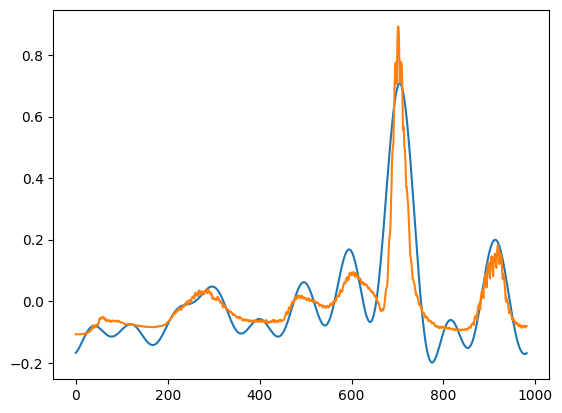

In [33]:
new_y = np.zeros(df_day.Infect.shape)
spec = np.fft.fft(df_day.Infect)
cn = np.abs((spec.real**2 + spec.imag**2)**(1/2))
theta = np.angle(spec)
Ts = np.mean(np.diff(df_day.DateTime))
fs = 1 / Ts
fs_day = fs * 60 * 60 * 24
Ts, fs
for n in range(11):
    new_y += 2 * cn[n] * np.cos(2 * np.pi * fs/len(new_y) * n * df_day.DateTime  + theta[n])
plt.plot((new_y - new_y.mean()) / np.max(new_y))
plt.plot((df.Infect - df.Infect.mean()) / np.max(df.Infect))

Только на 11ой гармонике мы добились +- совпадения по максимумам

In [34]:
dif = np.diff(new_y)
dif_change_sign_arr = ((np.roll(np.sign(dif), 1) - np.sign(dif)) != 0).astype(int)
dif_change_sign_indc = np.where(dif_change_sign_arr)

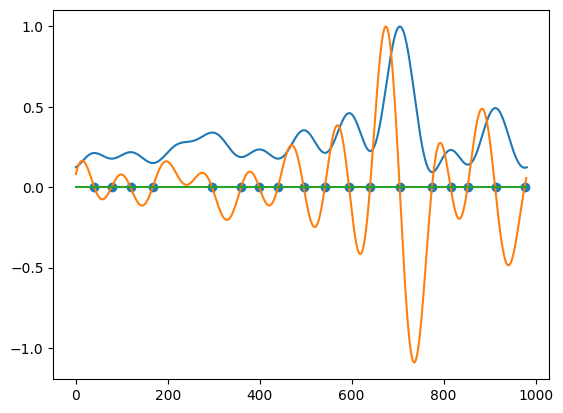

In [35]:
dif = np.diff(new_y)
plt.plot(new_y/ max(new_y))
plt.plot(dif/ max(dif))
plt.plot(np.zeros(len(dif)))
plt.scatter(dif_change_sign_indc, np.zeros(len(dif_change_sign_indc[0])))

Первый пичок соответствует максимуму, значит берем четные пички для оценки максимумов


In [47]:
max_indeces = dif_change_sign_indc[0][::2]
max_indeces

array([ 40, 119, 297, 399, 496, 595, 705, 816, 913])

In [48]:
max_el = np.take(new_y, max_indeces)
max_el

40     3.131598e+07
119    3.209294e+07
297    5.006582e+07
399    3.457807e+07
496    5.215147e+07
595    6.781557e+07
705    1.471798e+08
816    3.409257e+07
913    7.243626e+07
Name: DateTime, dtype: float64

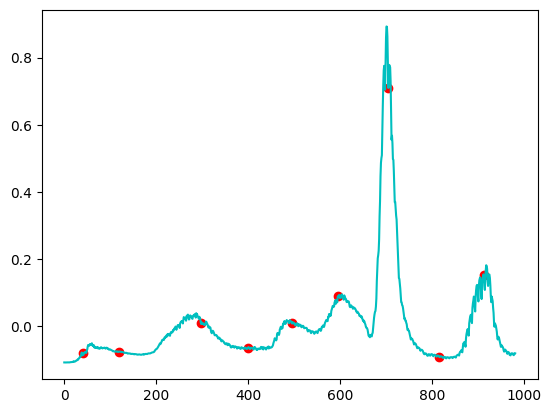

In [65]:
plt.plot(range(982), (df.Infect - df.Infect.mean())/max(df.Infect), color='c')
plt.scatter(max_indeces, ((df.Infect[max_indeces] - df.Infect.mean())/max(df.Infect)), color='r')

Отбросим точки, которые явно не соответсвуют пикам. Это точки 2,4,8

In [91]:
max_el

40     3.131598e+07
119    3.209294e+07
297    5.006582e+07
399    3.457807e+07
496    5.215147e+07
595    6.781557e+07
705    1.471798e+08
816    3.409257e+07
913    7.243626e+07
Name: DateTime, dtype: float64

In [95]:
res_max_el = max_el.drop([119, 399, 816])
res_max_el

40     3.131598e+07
297    5.006582e+07
496    5.215147e+07
595    6.781557e+07
705    1.471798e+08
913    7.243626e+07
Name: DateTime, dtype: float64

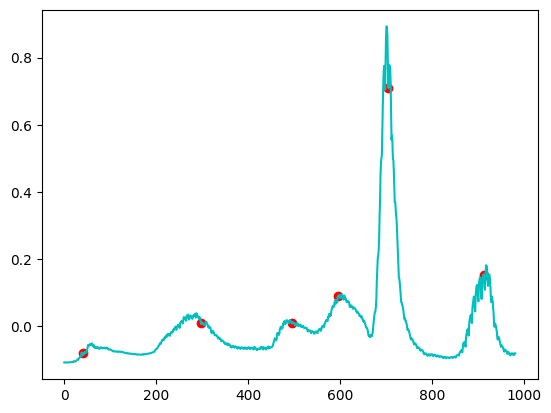

In [100]:
plt.plot(range(982), (df.Infect - df.Infect.mean())/max(df.Infect), color='c')
plt.scatter(res_max_el.index, ((df.Infect[res_max_el.index] - df.Infect.mean())/max(df.Infect)), color='r')

Переведем в дату

In [124]:
indeces = list(res_max_el.index)

In [130]:
dates_of_max = pd.DataFrame(df.loc[indeces].reset_index(drop=True))
dates_of_max.index +=1

In [131]:
dates_of_max

,DateTime,Infect,Recovery,Death
1,2020-04-21,5642,427,51
2,2021-01-03,24150,19847,504
3,2021-07-21,23704,22584,783
4,2021-10-28,40096,29318,1159
5,2022-02-15,166631,137881,704
6,2022-09-11,52829,37288,86
